In [15]:
import numpy as np 
import pandas as pd 
import yfinance as yf 
import matplotlib.pyplot as plt

from qp import sharpe, var_historical


In [16]:
tickers = ["SPY", "EFA", "EEM", "AGG", "GLD"]
start = "2020-01-01"

px = yf.download(tickers, start=start, auto_adjust=True, progress=False)["Close"]
ret = px.pct_change(fill_method=None).dropna()
ret.tail()

Ticker,AGG,EEM,EFA,GLD,SPY
Date,,,,,
2025-09-15,0.001691,0.007271,0.006667,0.010405,0.005324
2025-09-16,0.000397,0.007409,-0.002778,0.002006,-0.001377
2025-09-17,-0.001787,0.004337,-0.003749,-0.007715,-0.001242
2025-09-18,-0.002784,-0.002441,0.003871,-0.004006,0.004672
2025-09-19,0.000000,-0.002259,-0.003856,0.010607,0.004953


In [17]:
rf_annual = 0.04 
rf_daily = rf_annual / 252

sharpe_vals = ret.apply(lambda r: sharpe(r.values, risk_free=rf_daily))
sharpe_vals.sort_values(ascending=False)

Ticker
GLD    0.775053
SPY    0.580967
EFA    0.290900
EEM    0.140309
AGG   -0.462496
dtype: float64

In [18]:

# ^IRX laden (annualisiert in %) -> daily (Dezimal) & auf ret-Index ausrichten
irx = yf.download("^IRX", start=start, progress=False)["Close"] / 100.0
rf_daily_series = irx.reindex(ret.index).ffill() / 252  
rf_vec = getattr(rf_daily_series, "squeeze", lambda: rf_daily_series)()
rf_vec = rf_vec.to_numpy().reshape(-1) 


print("ret:", ret.shape, "rf_vec:", rf_vec.shape)


sharpe_irx = ret.apply(lambda col: sharpe(col.to_numpy(), risk_free=rf_vec, ddof=1))
sharpe_irx.sort_values(ascending=False)

/var/folders/hx/wjmq524d3rj5kn8qc61dk4dh0000gn/T/ipykernel_97111/501491191.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  irx = yf.download("^IRX", start=start, progress=False)["Close"] / 100.0


ret: (1436, 5) rf_vec: (1436,)


Ticker
GLD    0.858314
SPY    0.643516
EFA    0.357795
EEM    0.200324
AGG   -0.263890
dtype: float64

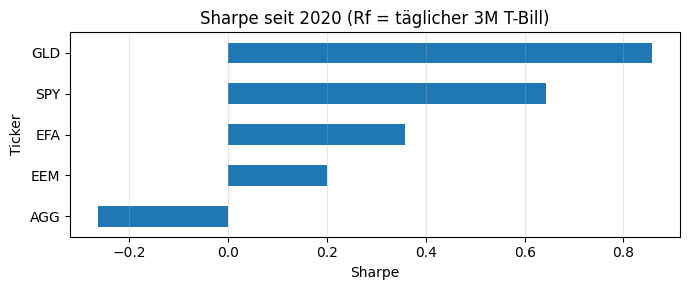

In [19]:
ax = sharpe_irx.sort_values().plot(kind="barh", figsize=(7,3),
                                   title="Sharpe seit 2020 (Rf = täglicher 3M T-Bill)")
ax.set_xlabel("Sharpe"); ax.grid(True, axis="x", alpha=0.3)
plt.tight_layout(); plt.show()

In [20]:
from qp.risk import sharpe
print(sharpe([0.01, 0.02, -0.01], 0.0))

6.928203230275507


VaR 95%  (1-Tages): 1.6441%
VaR 99%  (1-Tages): 2.3438%
VaR 99.9%(1-Tages): 3.0430%


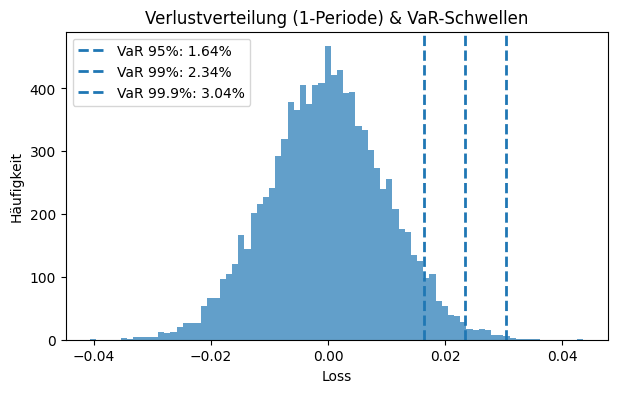

In [21]:

# Simulierte Tagesrenditen (leicht positiv, realistische Volatilität)
rng = np.random.default_rng(42)
returns = rng.normal(0.0003, 0.01, 10_000)

v95 = var_historical(returns, level=0.95)
v99 = var_historical(returns, level=0.99)
v999 = var_historical(returns, level=0.999)

print(f"VaR 95%  (1-Tages): {v95:.4%}")
print(f"VaR 99%  (1-Tages): {v99:.4%}")
print(f"VaR 99.9%(1-Tages): {v999:.4%}")

# Histogramm der Verluste mit VaR-Linien
losses = -returns
plt.figure(figsize=(7,4))
plt.hist(losses, bins=80, alpha=0.7)
for v, lbl in [(v95, "VaR 95%"), (v99, "VaR 99%"), (v999, "VaR 99.9%")]:
    plt.axvline(v, linestyle="--", linewidth=2, label=f"{lbl}: {v:.2%}")
plt.title("Verlustverteilung (1-Periode) & VaR-Schwellen")
plt.xlabel("Loss")
plt.ylabel("Häufigkeit")
plt.legend()
plt.show()